In [2]:
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
load_dotenv(find_dotenv())

True

### Reading the txt files from source directory

In [3]:
loader = DirectoryLoader('./source', glob="./*.py", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

In [5]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

c:\Users\LTahwineyi\Desktop\final_project\LLM_RAG_Model_Deployment\.conda\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
c:\Users\LTahwineyi\Desktop\final_project\LLM_RAG_Model_Deployment\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Creating Vectors from the Doc String using Embeddings

In [6]:
vectors = embeddings.embed_documents(doc_strings)

### Creating Retriever using Vector DB

In [7]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

### UMAP for Visulation of Vector Space along with Query

In [95]:
# ! pip install umap-learn

In [10]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

c:\Users\LTahwineyi\Desktop\final_project\LLM_RAG_Model_Deployment\.conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\LTahwineyi\Desktop\final_project\LLM_RAG_Model_Deployment\.conda\Lib\site-packages\umap\umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [11]:
umap_transformer.transform([vectors[0]])

array([[11.16189,  4.63735]], dtype=float32)

In [12]:
def embed_docs(vectors,umap_transformer):
    """Function to transform the vectors to 2 dimnesional vectors using UMAP"""
    return np.array([umap_transformer.transform([vector])[0] for vector in vectors])

In [13]:
### Base UPMAP vectors for all the chunks
base_umap_vectors = embed_docs(vectors=vectors,umap_transformer=umap_transformer)

### Embedding Visualization

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(base_umap_vectors[:, 0], base_umap_vectors[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

ModuleNotFoundError: No module named 'matplotlib'

### Function to Visualize the embeddings with the Query

In [12]:
def visualize_query_with_base_embeddings(query, embeddings, retriever, umap_transformer, base_umap_vectors):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    retrieved_documents = embeddings.embed_documents(page_contents)

    query_embeddings = embed_docs([q_embedding], umap_transformer)
    retrieved_embeddings = embed_docs(retrieved_documents, umap_transformer)

    plt.figure()
    plt.scatter(base_umap_vectors[:, 0], base_umap_vectors[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

c:\Users\LTahwineyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


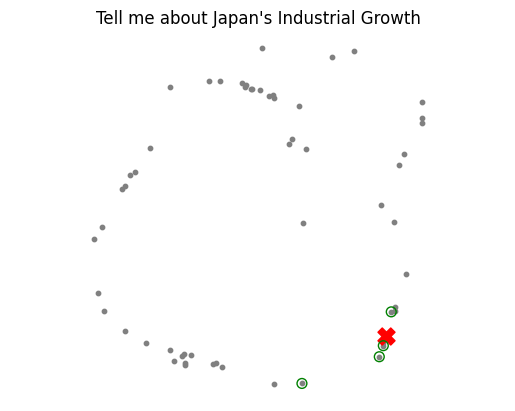

In [13]:
visualize_query_with_base_embeddings("Tell me about Japan's Industrial Growth", embeddings, retriever, umap_transformer, base_umap_vectors)

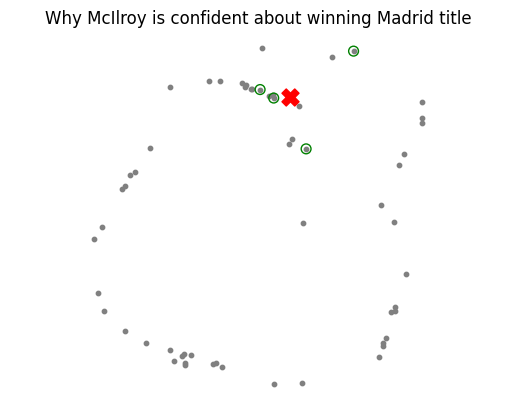

In [14]:
visualize_query_with_base_embeddings("Why McIlroy is confident about winning Madrid title", embeddings, retriever, umap_transformer, base_umap_vectors)

### Importing Togther API Mistal Model using the utils

In [13]:
from utils.llm import LLM

In [14]:
llm = LLM().get_llm_together()

c:\Users\LTahwineyi\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_together\llms.py:93: UserWarning: The completions endpoint, has 'max_tokens' as required argument. The default value is being set to 200 Consider setting this value, when initializing LLM
  warnings.warn(


### Pydantic Parser

In [15]:
from langchain.output_parsers import PydanticOutputParser,ListOutputParser,StructuredOutputParser
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List


class LineList(BaseModel):
    lines: list[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return lines


output_parser = LineListOutputParser()

### Query Rewriter or Augmented Queries

In [16]:
def query_rewrite(question:str):
    
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. 
    Original question: {question}
    Only provide the query, do not do numbering at the start of the questions.
    """


    prompt = ChatPromptTemplate.from_template(template)

    #output_parser = ListOutputParser

    chain = prompt | llm | output_parser

    result = chain.invoke({"question" : question})
    return result

In [17]:
query = "fetch a model query and anaylse it to correct it"

In [18]:
augmented_queries = query_rewrite(query)

OutputParserException: Invalid json output: Version 1: Identify and rectify errors in a given model query.
    Version 2: Review and amend a provided model query for accuracy.
    Version 3: Examine a model query and suggest improvements.
    Version 4: Correct any mistakes in a submitted model query.
    Version 5: Revise a model query to enhance its precision and effectiveness.

In [19]:
augmented_queries

NameError: name 'augmented_queries' is not defined

In [21]:
import re

pattern = r'[0-9]'

aug_queries = []
for line in augmented_queries:
    aug_queries.append(re.sub(pattern, '', line).replace('.','').strip())

aug_queries 


NameError: name 'augmented_queries' is not defined

### Retrieve the docouments for Augmented Queries

In [23]:
docs = [retriever.get_relevant_documents(query) for query in aug_queries]

### Removal of Duplicate Documents

In [22]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

AttributeError: 'tuple' object has no attribute 'page_content'

### Cross Encoder

In [23]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

### Creation of Query(Original Query) and Doc Pairs

In [24]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

### Getting Scores on Pairs using Cross Encoder

In [25]:
scores = cross_encoder.predict(pairs)
scores

IndexError: list index out of range

In [26]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

NameError: name 'scores' is not defined

### Reranking the documents

In [27]:
reranked_docs = [doc for _, doc in sorted_docs]
reranked_docs

NameError: name 'sorted_docs' is not defined